In [1]:
import warnings

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from joblib import dump
import os

from sklearn.model_selection import train_test_split
warnings.filterwarnings("ignore")

from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest
from sklearn.model_selection import GridSearchCV

from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.metrics import ConfusionMatrixDisplay, PrecisionRecallDisplay, classification_report,recall_score
from sklearn.metrics import accuracy_score
from imblearn.over_sampling import SMOTE
import pickle
from sklearn.cluster import KMeans

In [2]:
df = pd.read_csv('../data/processed/df_procesado.csv', index_col=0)

In [3]:
df

,Smoking Status,Physical Activity Level,Employment Status,Alcohol Consumption,Dietary Habits,Sleep Patterns,History of Mental Illness,History of Substance Abuse,Family History of Depression,Age_Adulthood,...,Status_Married,Status_Single,Status_Widowed,Log_Income,Education_Associate Degree,Education_Bachelor's Degree,Education_High School,Education_Master's Degree,Education_PhD,Target
Number of Children,,,,,,,,,,,,,,,,,,,,,
2,0,0,1,5,5,5,1,0,1,False,...,True,False,False,10.176056,False,True,False,False,False,1
1,0,10,0,10,10,5,1,0,0,True,...,True,False,False,10.662220,False,False,True,False,False,1
1,0,10,0,0,10,0,0,0,1,False,...,False,False,True,11.738736,False,False,False,True,False,0
3,0,5,1,5,5,10,0,0,0,True,...,False,False,False,9.209718,False,False,False,True,False,0
0,0,10,1,0,5,5,1,0,1,False,...,False,True,False,9.059062,False,False,True,False,False,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,5,5,0,0,0,0,0,0,0,False,...,True,False,False,11.601252,False,False,False,True,False,0
0,10,0,0,0,0,10,1,1,0,False,...,False,True,False,11.480009,False,True,False,False,False,1
0,0,10,0,5,5,5,0,0,1,True,...,True,False,False,11.256151,False,True,False,False,False,1


## División en train y test

In [4]:
x = df.drop(columns = 'Target')
y = df['Target']

In [5]:
x_train, x_test, y_train, y_test = train_test_split(x, y,
                                                    test_size=0.2,
                                                    random_state=42)

In [6]:
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(331014, 22)
(82754, 22)
(331014,)
(82754,)


Aplicamos SMOTE para ver si ayuda al desbalanceo leve de la target

In [7]:
smote = SMOTE(random_state=42)
x_resampled, y_resampled = smote.fit_resample(x_train, y_train)

PD: Confirmamos que ayudó mucho.

## Modelo 1: Regresión Logística

In [8]:
pipeline_lr = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=2)),
    ('classifier', LogisticRegression(random_state=42))
])
param_grid_lr = {
    'pca__n_components': [3, 5, 7],
    'classifier__C': [0.1, 1, 10],
    'classifier__penalty': ['l1', 'l2'],
    'classifier__solver': ['liblinear']
}

grid_search_lr = GridSearchCV(pipeline_lr, param_grid_lr, cv=5, scoring='recall')
grid_search_lr.fit(x_resampled, y_resampled)


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('pca', PCA(n_components=2)),
                                       ('classifier',
                                        LogisticRegression(random_state=42))]),
             param_grid={'classifier__C': [0.1, 1, 10],
                         'classifier__penalty': ['l1', 'l2'],
                         'classifier__solver': ['liblinear'],
                         'pca__n_components': [3, 5, 7]},
             scoring='recall')

Classification Report:
               precision    recall  f1-score   support

           0       0.69      0.46      0.55     55508
           1       0.34      0.58      0.43     27246

    accuracy                           0.50     82754
   macro avg       0.51      0.52      0.49     82754
weighted avg       0.57      0.50      0.51     82754

Recall: 0.5759377523306174
Matriz de confusión (Logistic Regression):


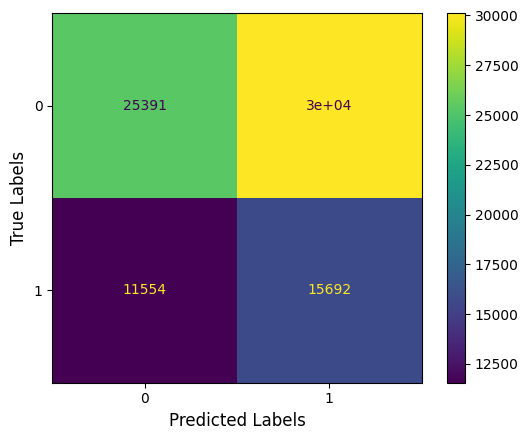

Curva de precision-recall (Logistic Regression):


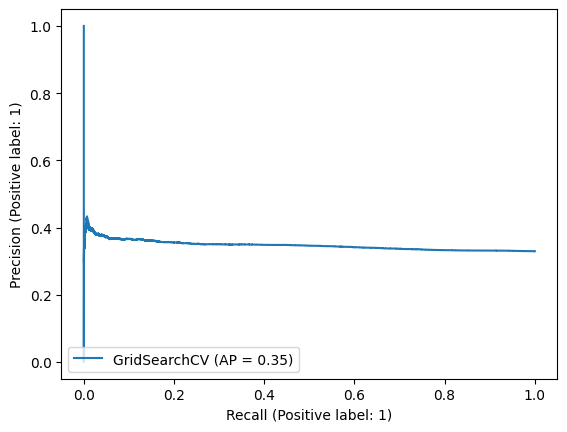

Best params (Logistic Regression): {'classifier__C': 1, 'classifier__penalty': 'l2', 'classifier__solver': 'liblinear', 'pca__n_components': 5}
Best recall (Logistic Regression): 0.55581788180091
Test recall: 0.5759377523306174


In [9]:
y_pred_lr = grid_search_lr.predict(x_test)

print("Classification Report:\n", classification_report(y_test, y_pred_lr))
recall = recall_score(y_test, y_pred_lr, average='binary')
print("Recall:", recall)
print("Matriz de confusión (Logistic Regression):")
ConfusionMatrixDisplay.from_estimator(grid_search_lr, x_test, y_test)
plt.xlabel('Predicted Labels', fontsize=12)
plt.ylabel('True Labels', fontsize=12)
plt.show()

print("Curva de precision-recall (Logistic Regression):")
PrecisionRecallDisplay.from_estimator(grid_search_lr, x_test, y_test)
plt.show()


print("Best params (Logistic Regression):", grid_search_lr.best_params_)
print("Best recall (Logistic Regression):", grid_search_lr.best_score_)
print("Test recall:", recall_score(y_test, y_pred_lr))

Vemos que este modelo claramente es insuficiente. Clasifica absolutamente todos los valores como negativo.

ACTUALIZACIÓN: Tras usar SMOTE, mejora mucho la RECALL

In [11]:
recall_tests = {'Logistic Regression' : 0.58}

## Modelo 2: Random Forest

In [12]:
pipeline_rf = Pipeline([
    ('pca', PCA(n_components=2)),
    ('classifier', RandomForestClassifier(random_state=42))
])

param_grid_rf = {
    'pca__n_components': [3],
    'classifier__n_estimators': [35, 40],
    'classifier__max_depth': [10, 15],
    'classifier__min_samples_split': [2, 3],
}

grid_search_rf = GridSearchCV(pipeline_rf, param_grid_rf, cv=5, scoring='recall',n_jobs=-1,verbose=1)
grid_search_rf.fit(x_resampled, y_resampled)
print(f"Best params (Random Forest): {grid_search_rf.best_params_}")
print(f"Best recall (Random Forest): {grid_search_rf.best_score_:.2f}")


Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best params (Random Forest): {'classifier__max_depth': 10, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 35, 'pca__n_components': 3}
Best recall (Random Forest): 0.66


Accuracy en el conjunto de prueba: 0.534644851004181
Classification Report:
               precision    recall  f1-score   support

           0       0.69      0.55      0.61     55508
           1       0.35      0.50      0.42     27246

    accuracy                           0.53     82754
   macro avg       0.52      0.53      0.51     82754
weighted avg       0.58      0.53      0.55     82754

Recall: 0.504000587242164
Matriz de confusión (Random Forest):


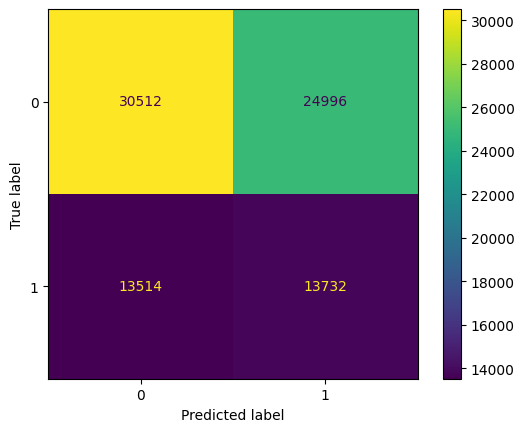

Curva de precision-recall (Random Forest):


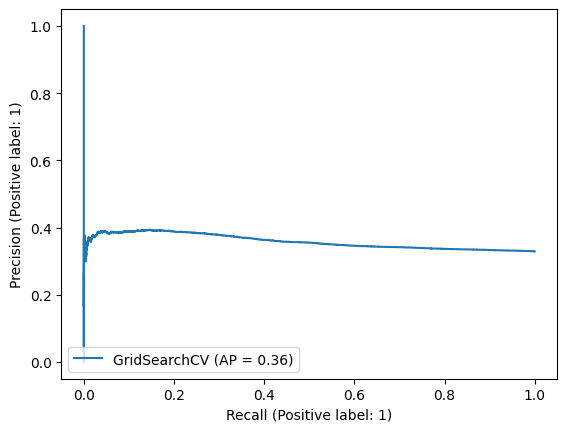

Best params (Random Forest): {'classifier__max_depth': 10, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 35, 'pca__n_components': 3}
Best recall (Random Forest): 0.6621295617048204
Test recall: 0.504000587242164


In [13]:
y_pred_rf = grid_search_rf.predict(x_test)

accuracy = accuracy_score(y_test, y_pred_rf)
print("Accuracy en el conjunto de prueba:", accuracy)
print("Classification Report:\n", classification_report(y_test, y_pred_rf))
recall = recall_score(y_test, y_pred_rf, average='binary')
print("Recall:", recall)
print("Matriz de confusión (Random Forest):")
ConfusionMatrixDisplay.from_estimator(grid_search_rf, x_test, y_test)
plt.show()

print("Curva de precision-recall (Random Forest):")
PrecisionRecallDisplay.from_estimator(grid_search_rf, x_test, y_test)
plt.show()

print("Best params (Random Forest):", grid_search_rf.best_params_)
print("Best recall (Random Forest):", grid_search_rf.best_score_)
print("Test recall:", recall_score(y_test, y_pred_rf))

In [14]:
recall_tests = {'Logistic Regression' : 0.58,
                'Random Forest': 0.50}

Mejora la recall con respecto a la regresión logística, pero no en test

## Modelo 3: XGBoost

In [28]:
from xgboost import XGBClassifier

In [29]:
pipeline_xgb = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=2)),
    ('classifier', XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='mlogloss'))
])

param_grid_xgb = {
    'pca__n_components': [15, 18],
    'classifier__n_estimators': [50, 55],
    'classifier__learning_rate': [0.1],
    'classifier__max_depth': [5],
    'classifier__subsample': [0.7]
}

grid_search_xgb = GridSearchCV(pipeline_xgb, param_grid_xgb, cv=5, scoring='recall',n_jobs=-1,verbose=1)
grid_search_xgb.fit(x_resampled, y_resampled)
print("Best params (XGBoost):", grid_search_xgb.best_params_)
print("Best recall (XGBoost):", grid_search_xgb.best_score_)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
Best params (XGBoost): {'classifier__learning_rate': 0.1, 'classifier__max_depth': 5, 'classifier__n_estimators': 50, 'classifier__subsample': 0.7, 'pca__n_components': 18}
Best recall (XGBoost): 0.5445802643138365


Accuracy en el conjunto de prueba: 0.6009256350146216
Matriz de confusión (XGBoost):


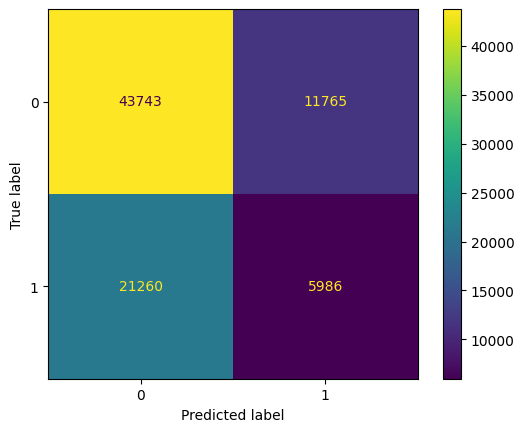

Curva de precision-recall (XGBoost):


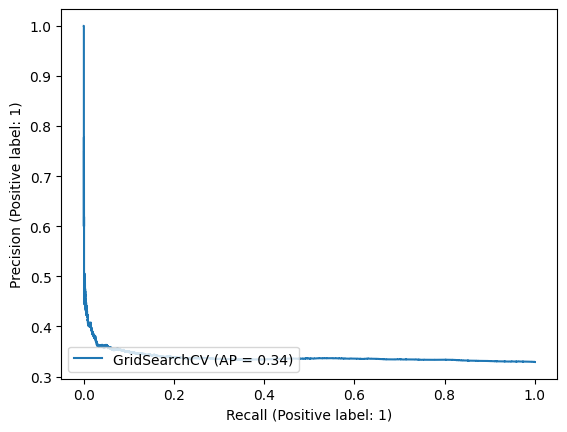

Best params (XGBoost): {'classifier__learning_rate': 0.1, 'classifier__max_depth': 5, 'classifier__n_estimators': 50, 'classifier__subsample': 0.7, 'pca__n_components': 18}
Best recall (XGBoost): 0.5445802643138365


In [ ]:
y_pred_xgb = grid_search_xgb.predict(x_test)
accuracy = accuracy_score(y_test, y_pred_xgb)
print("Accuracy en el conjunto de prueba:", accuracy)
print("Matriz de confusión (XGBoost):")
ConfusionMatrixDisplay.from_estimator(grid_search_xgb, x_test, y_test)
plt.show()

print("Curva de precision-recall (XGBoost):")
PrecisionRecallDisplay.from_estimator(grid_search_xgb, x_test, y_test)
plt.show()

print("Best params (XGBoost):", grid_search_xgb.best_params_)
print("Best recall (XGBoost):", grid_search_xgb.best_score_)
print("Test recall:", recall_score(y_test, y_pred_xgb))

In [15]:
recall_tests = {'Logistic Regression' : 0.58,
                'Random Forest': 0.50,
                'XGBoost' : 0.54}

No mejora al anterior

## Modelo 4: KNN

In [33]:
from sklearn.neighbors import KNeighborsClassifier

In [34]:
pipeline_knn = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=2)),
    ('classifier', KNeighborsClassifier())
])

param_grid_knn = {
    'pca__n_components': [5, 6, 7, 8],
    'classifier__n_neighbors': [1, 2 ,3, 4],
    'classifier__weights': ['distance', 'uniform']
}

grid_search_knn = GridSearchCV(pipeline_knn, param_grid_knn, cv=5, scoring='recall',n_jobs=-1,verbose=1)
grid_search_knn.fit(x_resampled, y_resampled)
print("Best params (KNN):", grid_search_knn.best_params_)
print("Best recall (KNN):", grid_search_knn.best_score_)

Fitting 5 folds for each of 32 candidates, totalling 160 fits
Best params (KNN): {'classifier__n_neighbors': 2, 'classifier__weights': 'distance', 'pca__n_components': 6}
Best recall (KNN): 0.6298708498365692


Accuracy en el conjunto de prueba: 0.5604321241269304
Best params (KNN): {'classifier__n_neighbors': 2, 'classifier__weights': 'distance', 'pca__n_components': 6}
Best recall (KNN): 0.6298708498365692
Matriz de confusión (KNN):


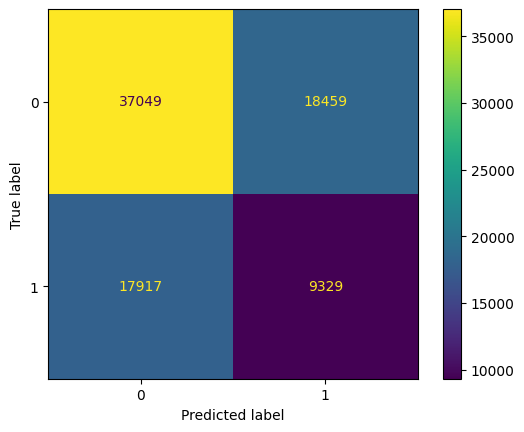

Curva de precision-recall (KNN):


In [ ]:
y_pred_knn = grid_search_knn.predict(x_test)

accuracy = accuracy_score(y_test, y_pred_knn)
print("Accuracy en el conjunto de prueba:", accuracy)
print("Best params (KNN):", grid_search_knn.best_params_)
print("Best recall (KNN):", grid_search_knn.best_score_)
print("Test recall:", recall_score(y_test, y_pred_knn))

print("Matriz de confusión (KNN):")
ConfusionMatrixDisplay.from_estimator(grid_search_knn, x_test, y_test)
plt.show()

print("Curva de precision-recall (KNN):")
(grid_search_knn, x_test, y_test)
plt.show()

In [17]:
recall_tests = {'Logistic Regression' : 0.58,
                'Random Forest': 0.50,
                'XGBoost' : 0.54,
                'KNN' : 0.66}

De momento, nuestro mejor modelo

## Modelo 5: SVM

In [ ]:
pipeline_svm = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=3)), 
    ('classifier', SVC(C=0.1, kernel='linear', random_state=42))  
])

param_grid = {
    'pca__n_components': [3],  
    'classifier__C': [0.01, 0.1], 
    'classifier__kernel': ['linear'], 
}
grid_search_SVM = GridSearchCV(
    estimator=pipeline_svm,  
    param_grid=param_grid,  
    scoring='recall',  
    cv=5,  
    verbose=2, 
    n_jobs=-1 
)

grid_search_SVM.fit(x_resampled, y_resampled)

y_pred_svm = grid_search_SVM.predict(x_test)

from sklearn.metrics import accuracy_score, recall_score

accuracy = accuracy_score(y_test, y_pred_svm)
recall = recall_score(y_test, y_pred_svm, average='binary') 

print("Accuracy en el conjunto de prueba:", accuracy)
print("Recall en el conjunto de prueba:", recall)

In [ ]:
best_model = pipeline_svm
with open('../models/best_model.pkl', 'wb') as archivo:
    pickle.dump(best_model, archivo)

In [ ]:
y_pred_svm = pipeline_svm.predict(x_test)

print("Matriz de confusión:")
ConfusionMatrixDisplay.from_estimator(grid_search_svm, x_test, y_test)
plt.show()

print("Curva de precision-recall:")
PrecisionRecallDisplay.from_estimator(grid_search_svm, x_test, y_test)
plt.show()

print("Best params:", grid_search_svm.best_params_)
print("Best recall:", grid_search_svm.best_score_)
print("Test recall:", recall_score(y_test, y_pred_svm))

NO hay resultados porque lo detuvimos tras 1h de espera en re-entrenos posteriores

## Modelo 6: LightGBM

In [18]:
from lightgbm import LGBMClassifier

In [20]:
pipeline_lgbm = Pipeline([
    ('pca', PCA(n_components=2)),
    ('classifier', LGBMClassifier())
])

param_grid_lgbm = {
    'pca__n_components': [5, 6, 8],
    'classifier__num_leaves': [20, 31, 50, 70],
    'classifier__learning_rate': [0.001, 0.005, 0.01],
    'classifier__n_estimators': [100, 300],
}

grid_search_lgbm = GridSearchCV(
    pipeline_lgbm,
    param_grid_lgbm,
    cv=5,
    scoring='recall',
    n_jobs=-1,
    verbose=1
)

grid_search_lgbm.fit(x_resampled, y_resampled)

print("Best params:", grid_search_lgbm.best_params_)
print("Best recall:", grid_search_lgbm.best_score_)

Fitting 5 folds for each of 72 candidates, totalling 360 fits


  File "c:\Users\hugom\AppData\Local\Programs\Python\Python311\Lib\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")


[LightGBM] [Info] Number of positive: 222053, number of negative: 222053
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001112 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 444106, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
Best params: {'classifier__learning_rate': 0.001, 'classifier__n_estimators': 100, 'classifier__num_leaves': 20, 'pca__n_components': 5}
Best recall: 0.6592968722474131


Matriz de confusión:


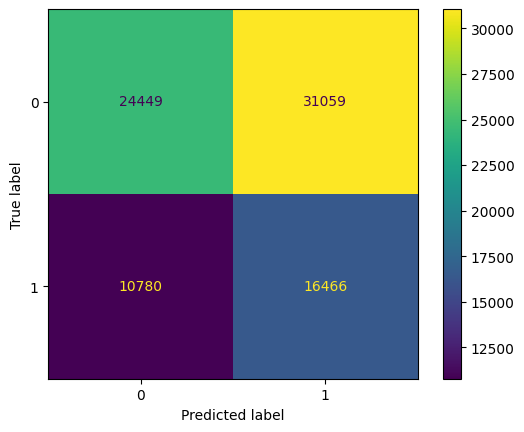

Curva de precision-recall:


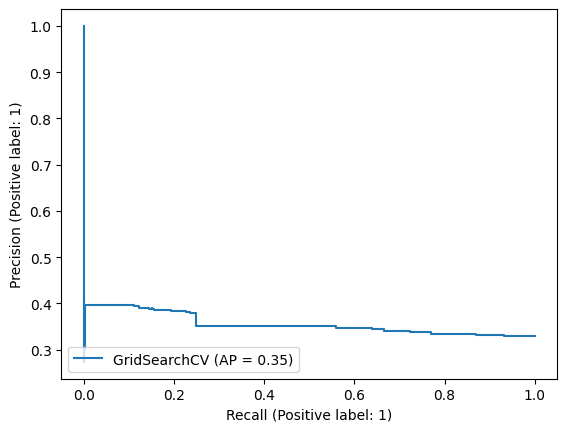

Best params: {'classifier__learning_rate': 0.001, 'classifier__n_estimators': 100, 'classifier__num_leaves': 20, 'pca__n_components': 5}
Best recall: 0.6592968722474131
Test recall: 0.6043455920135066


In [21]:
y_pred_lgbm = grid_search_lgbm.predict(x_test)

print("Matriz de confusión:")
ConfusionMatrixDisplay.from_estimator(grid_search_lgbm, x_test, y_test)
plt.show()

print("Curva de precision-recall:")
PrecisionRecallDisplay.from_estimator(grid_search_lgbm, x_test, y_test)
plt.show()

print("Best params:", grid_search_lgbm.best_params_)
print("Best recall:", grid_search_lgbm.best_score_)
print("Test recall:", recall_score(y_test, y_pred_lgbm))

La recall baja un poco, descartamos tras probar varias hiperparametrizaciones

In [37]:
recall_tests = {'Logistic Regression' : 0.58,
                'Random Forest': 0.50,
                'XGBoost' : 0.54,
                'KNN' : '- ',
                'LGBM' : 0.60,
                }

## Modelo 7: Red neuronal

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [24]:
model = keras.Sequential([
    layers.InputLayer(input_shape=(x_resampled.shape[1],)),
    layers.Dense(16, activation='relu'), 
    layers.Dense(8, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

In [25]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['Recall'])


In [26]:
history = model.fit(x_resampled, y_resampled, epochs=10, batch_size=32, validation_split=0.2, verbose=2)

Epoch 1/10
11103/11103 - 8s - 738us/step - Recall: 0.3830 - loss: 9.9312 - val_Recall: 0.9987 - val_loss: 0.0310
Epoch 2/10
11103/11103 - 7s - 650us/step - Recall: 0.3782 - loss: 4.0545 - val_Recall: 0.0668 - val_loss: 1.0251
Epoch 3/10
11103/11103 - 7s - 662us/step - Recall: 0.2235 - loss: 1.0926 - val_Recall: 0.0000e+00 - val_loss: 0.9905
Epoch 4/10
11103/11103 - 7s - 633us/step - Recall: 4.5035e-05 - loss: 0.6616 - val_Recall: 0.0000e+00 - val_loss: 0.9758
Epoch 5/10
11103/11103 - 7s - 636us/step - Recall: 0.0000e+00 - loss: 0.6616 - val_Recall: 0.0000e+00 - val_loss: 0.9745
Epoch 6/10
11103/11103 - 7s - 650us/step - Recall: 1.5012e-05 - loss: 0.6616 - val_Recall: 0.0000e+00 - val_loss: 0.9856
Epoch 7/10
11103/11103 - 7s - 638us/step - Recall: 0.0000e+00 - loss: 0.6616 - val_Recall: 0.0000e+00 - val_loss: 0.9786
Epoch 8/10
11103/11103 - 7s - 654us/step - Recall: 7.5058e-06 - loss: 0.6623 - val_Recall: 9.0068e-05 - val_loss: 0.9740
Epoch 9/10
11103/11103 - 7s - 635us/step - Recall: 1

In [27]:
evaluation = model.evaluate(x_test, y_test)
print(f"Loss: {evaluation[0]}, Recall: {evaluation[1]}")

2587/2587 ━━━━━━━━━━━━━━━━━━━━ 1s 510us/step - Recall: 9.7579e-06 - loss: 0.6391
Loss: 0.6383313536643982, Recall: 3.6702636862173676e-05


In [38]:
recall_tests = {'Logistic Regression' : 0.58,
                'Random Forest': 0.50,
                'XGBoost' : 0.54,
                'KNN' : '- ',
                'LGBM' : 0.60,
                'Red Neuronal' : 0.0
                }

Vemos que una red neuronal tampoco es el mejor modelo. De hecho, es el peor.

## Modelo 8: Kmeans

In [75]:
pipeline_kmeans = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=5)),
    ('kmeans', KMeans(random_state=42))
])

param_grid_kmeans = {
    'pca__n_components': [5],
    'kmeans__n_clusters': [3, 4], 
    'kmeans__init': ['k-means++'],  
    'kmeans__max_iter': [300],  
}

grid_search_kmeans = GridSearchCV(
    pipeline_kmeans,
    param_grid_kmeans,
    cv=3,
    scoring='recall_weighted', 
    n_jobs=-1,
    verbose=1
)

grid_search_kmeans.fit(x_resampled)

print("Best params (KMeans):", grid_search_kmeans.best_params_)
print("Best silhouette score (KMeans):", grid_search_kmeans.best_score_)

Fitting 3 folds for each of 2 candidates, totalling 6 fits
Best params (KMeans): {'kmeans__init': 'k-means++', 'kmeans__max_iter': 300, 'kmeans__n_clusters': 3, 'pca__n_components': 5}
Best silhouette score (KMeans): nan


## Modelo 9: SGDClassifier

In [8]:
from sklearn.linear_model import SGDClassifier

In [9]:
# parametros que daban buenos resultados de recall

pipeline_sgd = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=5)),
    ('classifier', SGDClassifier(random_state=42))
])

param_grid_sgd = {
    'pca__n_components': [4, 5, 6], 
    'classifier__loss': ['hinge'], 
    'classifier__alpha': [0.005, 0.03, 0.05],
    'classifier__penalty': ['elasticnet'],
}

grid_search_sgd = GridSearchCV(
    pipeline_sgd,
    param_grid_sgd,
    cv=5,
    scoring='recall',
    n_jobs=-1,
    verbose=1
)

grid_search_sgd.fit(x_resampled, y_resampled)

print("Best params (LGBM):", grid_search_sgd.best_params_)
print("Best recall (LGBM):", grid_search_sgd.best_score_)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
Best params (LGBM): {'classifier__alpha': 0.05, 'classifier__loss': 'hinge', 'classifier__penalty': 'elasticnet', 'pca__n_components': 4}
Best recall (LGBM): 0.678761348234294


Test recall: 0.772003229831902
Matriz de confusión:


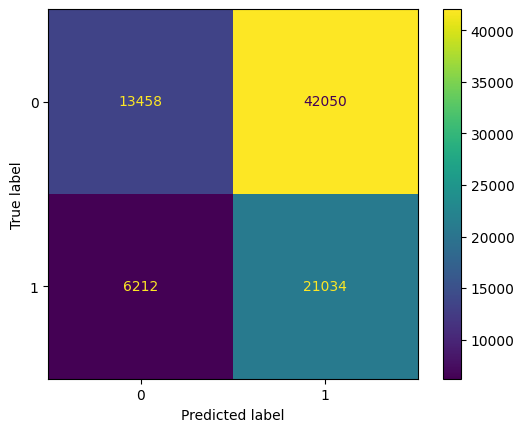

Curva de precision-recall:


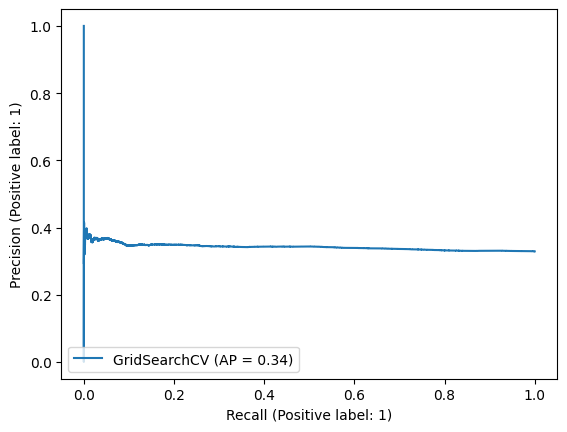

Best params: {'classifier__alpha': 0.03, 'classifier__loss': 'hinge', 'classifier__penalty': 'elasticnet', 'pca__n_components': 5}
Best recall: 0.7228996734363708
Test recall: 0.772003229831902


In [18]:
y_pred_sgd = grid_search_sgd.best_estimator_.predict(x_test)
print("Test recall:", recall_score(y_test, y_pred_sgd))

print("Matriz de confusión:")
ConfusionMatrixDisplay.from_estimator(grid_search_sgd, x_test, y_test)
plt.show()

print("Curva de precision-recall:")
PrecisionRecallDisplay.from_estimator(grid_search_sgd, x_test, y_test)
plt.show()

print("Best params:", grid_search_sgd.best_params_)
print("Best recall:", grid_search_sgd.best_score_)
print("Test recall:", recall_score(y_test, y_pred_sgd))

^^^^^^^Mejor modelo. No podemos usarlo porque al usar hinge, streamlit no puede calcular predict.proba. Buscamos soluciones

In [12]:
pipeline_sgd2 = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=5)),
    ('classifier', SGDClassifier(random_state=42,loss='log'))
])

param_grid_sgd2 = {
    'pca__n_components': [4, 5], 
    'classifier__loss': ['hinge'], 
    'classifier__alpha': [0.005, 0.03, 0.05],
    'classifier__penalty': ['elasticnet'],
}

grid_search_sgd2 = GridSearchCV(
    pipeline_sgd2,
    param_grid_sgd2,
    cv=5,
    scoring='recall',
    n_jobs=-1,
    verbose=1
)

best_model = grid_search_sgd2.best_estimator_
calibrated_model = CalibratedClassifierCV(best_model, cv=5)
calibrated_model.fit(x_resampled, y_resampled)

# grid_search_sgd.fit(x_resampled, y_resampled)

# print("Best params (LGBM):", grid_search_sgd.best_params_)
# print("Best recall (LGBM):", grid_search_sgd.best_score_)

print("Best params (LGBM):", calibrated_model.best_params_)
print("Best recall (LGBM):", calibrated_model.best_score_)

AttributeError: 'GridSearchCV' object has no attribute 'best_estimator_'

In [11]:
pipeline_sgd3 = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=5)),
    ('classifier', SGDClassifier(random_state=42,loss='log'))
])

param_grid_sgd3 = {
    'pca__n_components': [4, 5],  # Variedad en el número de componentes
    'classifier__loss': ['log_loss'],  # Diferentes funciones de pérdida
    'classifier__alpha': [0.001, 0.005, 0.01],  # Regularización
    'classifier__penalty': ['l2', 'l1', 'elasticnet', None],  # Diferentes tipos de penalización
    'classifier__l1_ratio': [0.15, 0.25, 0.5],  # Proporción de mezcla de L1 y L2 (solo para 'elasticnet')

}

grid_search_sgd3 = GridSearchCV(
    pipeline_sgd3,
    param_grid_sgd3,
    cv=5,
    scoring='recall',
    n_jobs=-1,
    verbose=3
)

grid_search_sgd3.fit(x_resampled, y_resampled)

print("Best params (LGBM):", grid_search_sgd3.best_params_)
print("Best recall (LGBM):", grid_search_sgd3.best_score_)

Fitting 5 folds for each of 72 candidates, totalling 360 fits
Best params (LGBM): {'classifier__alpha': 0.005, 'classifier__l1_ratio': 0.15, 'classifier__loss': 'log_loss', 'classifier__penalty': 'l1', 'pca__n_components': 4}
Best recall (LGBM): 0.5910030297686422


Test recall: 0.528187623871394
Matriz de confusión:


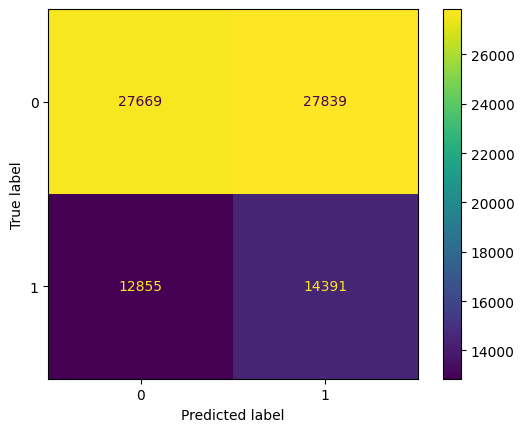

Curva de precision-recall:


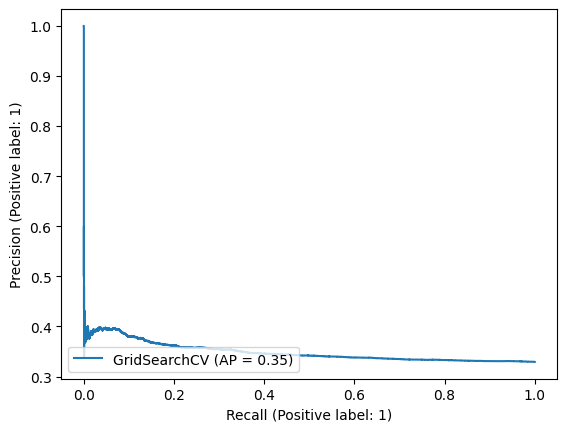

Best params: {'classifier__alpha': 0.005, 'classifier__l1_ratio': 0.15, 'classifier__loss': 'log', 'classifier__penalty': 'l1', 'pca__n_components': 4}
Best recall: 0.5912777527102204
Test recall: 0.528187623871394


In [14]:
y_pred_sgd3 = grid_search_sgd3.best_estimator_.predict(x_test)
print("Test recall:", recall_score(y_test, y_pred_sgd3))

print("Matriz de confusión:")
ConfusionMatrixDisplay.from_estimator(grid_search_sgd3, x_test, y_test)
plt.show()

print("Curva de precision-recall:")
PrecisionRecallDisplay.from_estimator(grid_search_sgd3, x_test, y_test)
plt.show()

print("Best params:", grid_search_sgd3.best_params_)
print("Best recall:", grid_search_sgd3.best_score_)
print("Test recall:", recall_score(y_test, y_pred_sgd3))

(He probado otros hiperparámetros y por eso ha bajado la recall, pero sí que me dió 0.77)

In [67]:
recall_tests = {'Logistic Regression' : 0.58,
                'Random Forest': 0.50,
                'XGBoost' : 0.54,
                'KNN' : '- ',
                'SVM' : 0.49,
                'LGBM' : 0.60,
                'Red Neuronal' : 0.0,
                'SDG' : 0.77
                }

# Modelo Final

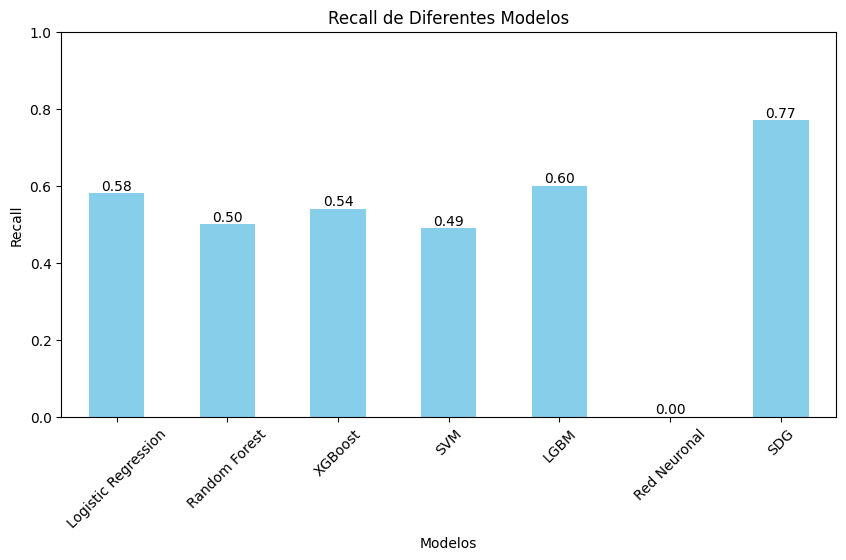

In [68]:
recall_df = pd.DataFrame.from_dict(recall_tests, orient='index', columns=['Recall'])

recall_df = recall_df[recall_df['Recall'].apply(lambda x: isinstance(x, (int, float)))]

plt.figure(figsize=(10, 5))
ax = recall_df['Recall'].plot(kind='bar', color='skyblue', title='Recall de Diferentes Modelos', ylim=(0, 1))
plt.xlabel('Modelos')
plt.ylabel('Recall')
plt.xticks(rotation=45)
[ax.text(i, v, f"{v:.2f}", ha='center', va='bottom') for i, v in enumerate(recall_df['Recall'])]  # Anotaciones
plt.show()

este modelo 1 es el SGDClassifier, mejores resultados pero con hinge

In [ ]:
# NO TOCAR
# import pickle
# best_model = grid_search_sgd
# with open('../models/best_model.pkl', 'wb') as archivo:
#     pickle.dump(best_model, archivo)

Nos quedamos en principio con el SGD3, peores resultados que el inicial, pero posiblidad de mejora

In [14]:
best_model2 = grid_search_sgd3

In [22]:
import pickle
best_model2 = grid_search_sgd3
with open('../models/best_model2.pkl', 'wb') as archivo:
    pickle.dump(best_model2, archivo)

Exportamos también con joblib para optiizar el deploy de streamlit

In [12]:
best_model_app = grid_search_sgd3.best_estimator_

In [13]:
dump(best_model_app, 'best_model_app.joblib')

['best_model_app.joblib']